# VQVAE + DCGAN generator
Aryaman Sharma 46066853

## 1) VQVAE reconstruction

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision as vision
import torchvision.transforms as tfs
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Import models
from model.residualBlock import Residual_block
from model.encoder import Encoder
from model.decoder import Decoder
from model.vector_quantizer import VectorQuantizer
from model.vqvae import VQVAE

#### Defining parameters

In [2]:
# define VQVAE parameters
BATCH_SIZE = 32
EPOCHS = 2
LR = 1e-3
DEVICE = 'cuda'
NUM_HIDDENS = 128 # hidden blocks for encoder convolution 
RESIDUAL_INTER = 32 # intermediary residual block channels
NUM_EMBEDDINGS = 512 # number of embeddings for codebook
EMBEDDING_DIM = 64 # dimension of each embedding
COMMITMENT_COST = 0.25 # beta term in loss function
TRAIN_DATA_PATH = '/content/vqvae_data/train' # path to training data
TEST_DATA_PATH = '/content/vqvae_data/test' # path to test data
DATA_VARIANCE = 0.0338 # evaluated seperately on training data

#### Data loading

In [3]:
transform = tfs.Compose([
    tfs.ToTensor()
])
train_ds = vision.datasets.ImageFolder(TRAIN_DATA_PATH, transform=transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_ds = vision.datasets.ImageFolder(TEST_DATA_PATH, transform=transform)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

#### Model initialisation and training

In [4]:
model = VQVAE(NUM_HIDDENS, RESIDUAL_INTER, NUM_EMBEDDINGS, EMBEDDING_DIM, COMMITMENT_COST)
model.to(DEVICE)

# Init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
training_reconstruction_loss = []

def train_function(dataloader, model, optimizer):
  size = len(dataloader.dataset)
  losses = []
  for batch, (X,_) in enumerate(dataloader):
    X = X.to(device=DEVICE)

    optimizer.zero_grad()
    vq_loss, data_recon = model(X)

    recon_error = F.mse_loss(data_recon, X) / DATA_VARIANCE
    loss = recon_error + vq_loss
    loss.backward()
    optimizer.step()
    losses.append(recon_error.item())

  losses = sum(losses)/len(losses)
  return losses
   
for i in range(EPOCHS):
  print(f"EPOCH = {i+1}  ")
  lo = train_function(train_dl, model, optimizer)
  training_reconstruction_loss.append(lo)
  print(f"Reconstruction loss: {lo}")

EPOCH = 1  
Reconstruction loss: 0.4598403800500939
EPOCH = 2  
Reconstruction loss: 0.16471374323529914


#### Reconstruction Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


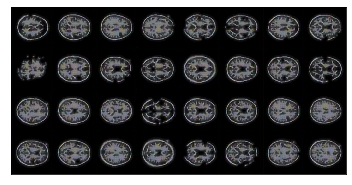

In [5]:
test_real = next(iter(test_dl)) # load some from test dl
test_real = test_real[0]
test_real = test_real.to(DEVICE)
pre_conv = model.conv1(model.encoder(test_real)) # encoder, reshape
_, test_quantized, _, _ = model.vq(pre_conv)
test_reconstructions = model.decoder(test_quantized)

def show(img):
  """
  Plotting func
  """
  npimg = img.numpy()
  fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)

# show reconstructed images
show(make_grid(test_reconstructions.cpu()))

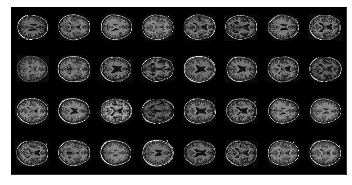

In [6]:
# show real
show(make_grid(test_real.cpu()))

#### Visualising embedding, codebook_indices, quantized outputs

tensor([134, 418], device='cuda:0')


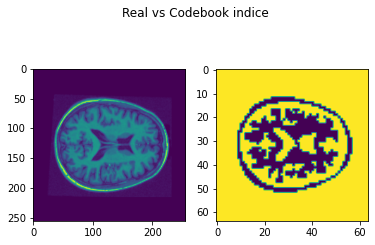

In [7]:
test_input = next(iter(test_dl))
test_input = test_input[0][0]
test_input = test_input.unsqueeze(0)
test_input.shape
test_input = test_input.to('cuda')
a = model.encoder(test_input)
a = model.conv1(a)
_,a,b,z = model.vq(a)
c = model.decoder(a)
# z is codebook indice
# Plot codebook indice
pi = z.view(64,64)
print(torch.unique(z))
pi = pi.to('cpu')
ii = pi.detach().numpy()

test_input = test_input[0][0].cpu().detach().numpy()
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Real vs Codebook indice')
ax1.imshow(test_input)
ax2.imshow(ii)


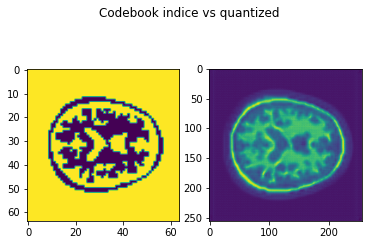

In [8]:
# Convert Codebook indice to quatized 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Codebook indice vs quantized')
zz = model.vq.get_quantized(z)
zzz = model.decoder(zz)
immi = zzz[0] 
immi = immi.to('cpu')
immi = immi.detach().numpy()
ax2.imshow(immi[1])
ax1.imshow(z.cpu().view(64,64).detach().numpy())

## 2) Generating codebook indices using DCGAN

In [31]:
from model.generator import Generator
from model.discriminator import Discriminator

LR_GAN = 2e-4
BATCH_SIZE_GAN = 256
EPOCHS_GAN = 20
TRAIN_DATA_PATH = '/content/vqvae_data/train/train/'

#### Define Dataset, DataLoader

In [32]:
from torch.utils.data import Dataset
import os
from PIL import Image

# define dataset
class GanData(Dataset):
    def __init__(self, model, transforms):
        self.model = model
        self.images = os.listdir(TRAIN_DATA_PATH)
        self.tfs = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, x):
        img_path = TRAIN_DATA_PATH + self.images[x]
        image = Image.open(img_path).convert('RGB')
        image = self.tfs(image)
        image = image.unsqueeze(dim=0)
        image = image.to('cuda')
        encoded_output = self.model.encoder(image)
        z = model.conv1(encoded_output)
        _,_,_,z = model.vq(z)
        z = z.float().to('cuda')
        z = z.view(64,64)
        z = torch.stack((z,z,z),0) # GAN uses 3 channel inputs
        return z,z

# Create ds and dl
transform = tfs.Compose([
    tfs.ToTensor()
])
gan_ds = GanData(model, transform)
gan_dl = DataLoader(gan_ds, batch_size=BATCH_SIZE_GAN)

#### Train DCGAN

In [33]:
# Initialise models
generator = Generator()
discriminator = Discriminator()
for l in generator.modules():
    if isinstance(l, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(l.weight.data, 0.0, 0.02)

for l in discriminator.modules():
    if isinstance(l, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(l.weight.data, 0.0, 0.02)

# criterion
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
loss = nn.BCELoss()

generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)

# Train
for epoch in range(EPOCHS_GAN):
    print(f"Epoch: {epoch+1}\n ************************************************")
    for batch, (image, _) in enumerate(gan_dl):
        image = image.to(DEVICE)
        z = torch.randn(BATCH_SIZE, 100, 1, 1).to(DEVICE)
        generated_image = generator(z)
        
        # Getting discriminator loss
        disc_with_real = discriminator(image).reshape(-1)
        loss_disc_real = loss(disc_with_real, torch.ones_like(disc_with_real))
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
        disc_fake = discriminator(generated_image.detach()).reshape(-1)
        loss_disc_fake = loss(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        discriminator.zero_grad()
        loss_disc.backward()
        optimizer_dis.step()
        
        
        # Generator
        output = discriminator(generated_image).reshape(-1)
        loss_gen = loss(output, torch.ones_like(output))
        generator.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
        
        if batch % 100 == 0:
            print(
                f"Batch {batch} lossD: {loss_disc}, lossG: {loss_gen}]"
            )

Epoch: 1
 ************************************************
Batch 0 lossD: 0.6925985217094421, lossG: 1.133986473083496]
Epoch: 2
 ************************************************
Batch 0 lossD: 0.4064171314239502, lossG: 1.3814022541046143]
Epoch: 3
 ************************************************
Batch 0 lossD: 0.6066166162490845, lossG: 1.1741185188293457]
Epoch: 4
 ************************************************
Batch 0 lossD: 0.4469057321548462, lossG: 3.3109512329101562]
Epoch: 5
 ************************************************
Batch 0 lossD: 0.28465187549591064, lossG: 2.78061842918396]
Epoch: 6
 ************************************************
Batch 0 lossD: 0.35850560665130615, lossG: 3.923455238342285]
Epoch: 7
 ************************************************
Batch 0 lossD: 0.9215997457504272, lossG: 4.8759541511535645]
Epoch: 8
 ************************************************
Batch 0 lossD: 0.19792553782463074, lossG: 3.744086742401123]
Epoch: 9
 ************************

## 3) Generate codebook indice from DCGAN -> generate intented image

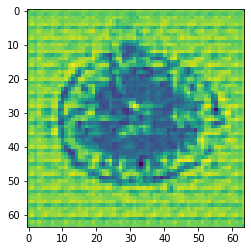

In [34]:
# Generate random code from gan
x = torch.randn(1, 100, 1, 1).to(DEVICE)
with torch.no_grad():
  f1 = generator(x)

# Visualise generated code
generated_code_indice = f1[0][0]
generated_code_indice = generated_code_indice.to('cpu')
generated_code_indice = generated_code_indice.detach().numpy()
plt.imshow(generated_code_indice)

In [35]:
generated_code_indice =  f1[0][0]
generated_code_indice = torch.flatten(generated_code_indice)

#### Interval based index mapping
Converting gan output to codebook indice

In [36]:
# Obtained from code indice unique values by VQVAE
unique_vals = [134, 418]

In [37]:
input_min = torch.min(generated_code_indice)
input_max = torch.max(generated_code_indice)

num_intervals = len(unique_vals) 
interval_size = (input_max - input_min)/num_intervals

for i in range(0, num_intervals):
  MIN = input_min + i*interval_size
  generated_code_indice[torch.logical_and(MIN<= generated_code_indice, generated_code_indice<=(MIN+interval_size))] = unique_vals[i]

In [38]:
torch.unique(generated_code_indice)

tensor([134., 418.], device='cuda:0')

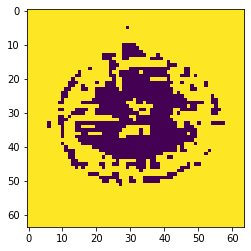

In [39]:
# Visualise generated codebook indice
ffqq = generated_code_indice
ffqq = ffqq.view(64,64)
ffqq = ffqq.to('cpu')
ffqq = ffqq.detach().numpy()
plt.imshow(ffqq)

#### Decode 

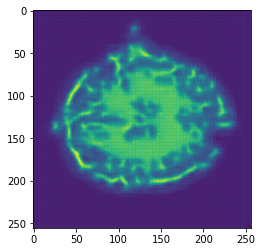

In [40]:
generated_code_indice = generated_code_indice.long()
generated_output = model.vq.get_quantized(generated_code_indice)
generated_output = model.decoder(generated_output)
# Visualise
tt = generated_output[0][0]
tt = tt.to('cpu')
tt = tt.detach().numpy()
plt.imshow(tt)

## 4) SSIM

100%|██████████| 9664/9664 [01:14<00:00, 130.50it/s]


SSIM was >0.60 against 7809 images
Max SSIM with case_294_slice_27.nii.png = 0.6989542682294593


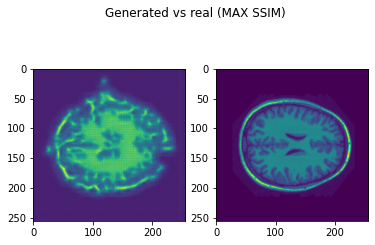

In [50]:
from skimage.metrics import structural_similarity as ssim
import cv2
from tqdm import tqdm

# Load test image for SSIM
images = os.listdir('/content/vqvae_data/train/train')
max_ssim = 0
max_ssim_image = None
accepted_ssim_count = 0
for image_name in tqdm(images):
  img_path = '/content/vqvae_data/train/train/' + image_name
  image = Image.open(img_path).convert('RGB')
  tfss = tfs.Compose([
      tfs.ToTensor()
  ])
  image = tfss(image)
  image = image.unsqueeze(0)

  image1 = generated_output[0][0].to('cpu').detach().numpy()
  image2 = image[0][0].to('cpu').detach().numpy()
  ssim_val = ssim(image1, image2)
  if ssim_val > 0.6:
    accepted_ssim_count += 1
    if ssim_val > max_ssim:
      max_ssim = ssim_val
      max_ssim_image_name = image_name
      max_ssim_image = image2

print(f"SSIM was >0.60 against {accepted_ssim_count} images")
print(f"Max SSIM with {max_ssim_image_name} = {max_ssim}")
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Generated vs real (MAX SSIM)')
ax1.imshow(tt)
ax2.imshow(max_ssim_image)